In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
housing = pd.read_csv('Housing.csv')

# Preparing the data for modeling

- Encoding:
    - Converting binary variables to 1/0
    - Other categorical variables to dummy variables

- Splitting into train and test
- Rescaling of variables

In [3]:
# yes/no variables

varlist = ['mainroad', 'guestroom', 'basement',
           'hotwaterheating', 'airconditioning', 'prefarea']

housing[varlist] = housing[varlist].apply(lambda x: x.map({'yes':1, 'no':0}))

In [4]:
# dropping redundant dummy variable

status = pd.get_dummies(housing['furnishingstatus'], dtype = int, drop_first=True)

In [5]:
# concat the dummy df to the original df
# Why axis = 1? That is because we want to join the dfs horizontally
housing = pd.concat([housing, status], axis = 1)
housing.head(5)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,0,0


In [6]:
housing = housing.drop('furnishingstatus', axis = 1)

In [7]:
df_train, df_test = train_test_split(housing, train_size=0.7, random_state=100)

In [8]:
'''
The below is in accordance to scaling
fit() -> learns xmin, xmax -> only performed for the training set
transform() -> x-xmin / xmax - xmin -> only performed for the test set
fit_transform() -> fit + transform
'''

'\nThe below is in accordance to scaling\nfit() -> learns xmin, xmax -> only performed for the training set\ntransform() -> x-xmin / xmax - xmin -> only performed for the test set\nfit_transform() -> fit + transform\n'

In [9]:
# Rescaling the data
scaler = MinMaxScaler()

# create a list of numeric vars
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories',
            'parking', 'price']

# fit on data
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

### Training the model

In [10]:
# Since area is highly correlated to price, we would start off with area as our first predictor variable
y_train = df_train.pop('price')
X_train = df_train

### RFE

In [11]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm , n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

In [12]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('area', True, 1),
 ('bedrooms', True, 1),
 ('bathrooms', True, 1),
 ('stories', True, 1),
 ('mainroad', True, 1),
 ('guestroom', True, 1),
 ('basement', False, 3),
 ('hotwaterheating', True, 1),
 ('airconditioning', True, 1),
 ('parking', True, 1),
 ('prefarea', True, 1),
 ('semi-furnished', False, 4),
 ('unfurnished', False, 2)]

In [13]:
col = X_train.columns[rfe.support_]
col

Index(['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom',
       'hotwaterheating', 'airconditioning', 'parking', 'prefarea'],
      dtype='object')

In [14]:
X_train.columns[~rfe.support_]

Index(['basement', 'semi-furnished', 'unfurnished'], dtype='object')

In [15]:
X_train_rfe = X_train[col]

In [16]:
X_train_rfe = sm.add_constant(X_train_rfe)

lm = sm.OLS(y_train, X_train_rfe).fit()

In [17]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     74.89
Date:                Mon, 29 Jul 2024   Prob (F-statistic):           1.28e-82
Time:                        14:44:52   Log-Likelihood:                 374.65
No. Observations:                 381   AIC:                            -727.3
Df Residuals:                     370   BIC:                            -683.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0027      0.018      0.151      0.880      -0.033       0.038
area                0.2363      0.030      7.787      0.000       0.177       0.296
bedrooms            0.0661      0.037      1.794      0.074      -0.006       0.139
bathrooms           0.1982      0.022      8.927      0.000       0.155       0.242
stories             0.0977      0.019      5.251      0.000       0.061       0.134
mainroad            0.0556      0.014      3.848      0.000       0.027       0.084
guestroom           0.0381      0.013      2.934      0.004       0.013       0.064
hotwaterheating     0.0897      0.022      4.104      0.000       0.047       0.133
airconditioning     0.0711      0.011      6.235      0.000       0.049       0.093
parking             0.0637      0.018      3.488      0.001       0.028       0.100
prefarea            0.0643      0.012      5.445      0.000       0.041       0.088
==============================================================================
Omnibus:                       86.105   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              286.069
Skew:                           0.992   Prob(JB):                     7.60e-63
Kurtosis:                       6.753   Cond. No.                         13.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
X_train_new = X_train_rfe.drop(['bedrooms'], axis = 1)

In [19]:
X_train_lm = sm.add_constant(X_train_new)

lm = sm.OLS(y_train, X_train_lm).fit()

In [20]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     82.37
Date:                Mon, 29 Jul 2024   Prob (F-statistic):           6.67e-83
Time:                        14:45:03   Log-Likelihood:                 373.00
No. Observations:                 381   AIC:                            -726.0
Df Residuals:                     371   BIC:                            -686.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0242      0.013      1.794      0.074      -0.002       0.051
area                0.2367      0.030      7.779      0.000       0.177       0.297
bathrooms           0.2070      0.022      9.537      0.000       0.164       0.250
stories             0.1096      0.017      6.280      0.000       0.075       0.144
mainroad            0.0536      0.014      3.710      0.000       0.025       0.082
guestroom           0.0390      0.013      2.991      0.003       0.013       0.065
hotwaterheating     0.0921      0.022      4.213      0.000       0.049       0.135
airconditioning     0.0710      0.011      6.212      0.000       0.049       0.094
parking             0.0669      0.018      3.665      0.000       0.031       0.103
prefarea            0.0653      0.012      5.513      0.000       0.042       0.089
==============================================================================
Omnibus:                       91.542   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              315.402
Skew:                           1.044   Prob(JB):                     3.25e-69
Kurtosis:                       6.938   Cond. No.                         10.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
X_train_new.columns

Index(['const', 'area', 'bathrooms', 'stories', 'mainroad', 'guestroom',
       'hotwaterheating', 'airconditioning', 'parking', 'prefarea'],
      dtype='object')

In [22]:
X_train_new = X_train_new.drop(['const'], axis=1)

- how to know if the predictor is a good fit
    - statistcial signifcance of the variables
    - VIFs

In [23]:
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values, i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending=False)
vif

,Features,VIF
0,area,4.52
3,mainroad,4.26
2,stories,2.12
7,parking,2.10
6,airconditioning,1.75
1,bathrooms,1.58
8,prefarea,1.47
4,guestroom,1.30
5,hotwaterheating,1.12


### Residual Analysis

In [24]:
y_train_pred = lm.predict(X_train_lm)
y_train_pred

359    0.136896
19     0.471955
159    0.318751
35     0.514123
28     0.481968
         ...   
526    0.105859
53     0.475592
350    0.261818
79     0.451167
520    0.200000
Length: 381, dtype: float64

Text(0.5, 0, 'Errors')

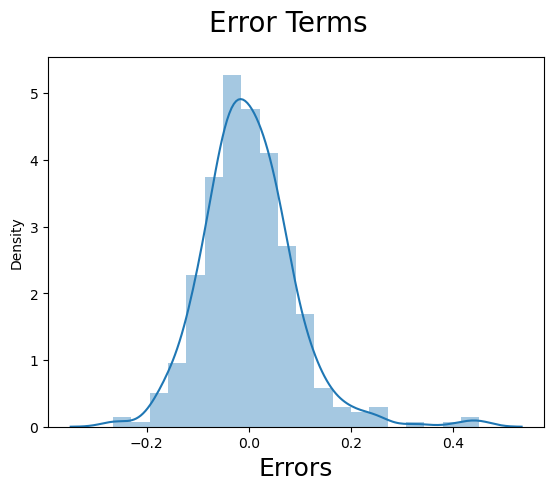

In [26]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

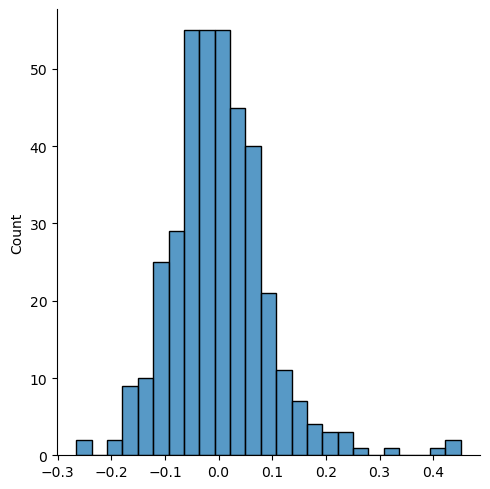

In [27]:
res = y_train - y_train_pred
sns.displot(res)

### Predictions and evaluations on the test set

In [ ]:
# create a list of numeric vars
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories',
            'parking', 'price']

# fit on data
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head(5)

In [ ]:
y_test = df_test.pop('price')
X_test = df_test

In [ ]:
X_train_new = X_train_new.drop(['const'], axis = 1)

In [ ]:
X_test_sm = X_test[X_train_new.columns]
X_test_sm = sm.add_constant(X_test)
X_test_sm.head()

- Now corresponding to the training set we need to remove the columns that don't make up the perfect model

In [ ]:
y_test_pred = lm.predict(X_test_sm)
y_test_pred

In [ ]:
# evaluate r2 score

r2_score(y_true =y_test, y_pred = y_test_pred)

In [ ]:
r2_score(y_true =y_train, y_pred = y_train_pred)

- As one can observe the values are almost similar on the test set and the train set, which means the model works just fine